In [1]:
import fiona
import shapely
from shapely.geometry import *
import pandas as pd
import geopandas as gpd
import numpy as np

import descartes
import shapely.ops as ops

import matplotlib.pyplot as plt
%matplotlib inline

/Users/Ben/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [12]:
from math import radians, cos, sin, asin, sqrt

def haversine(p1, p2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    Points are ordered (lon, lat)
    """
    lon1, lat1 = p1[0], p1[1]
    lon2, lat2 = p2[0], p2[1]
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles
    return c * r


def to_xy(point):
    p = point.xy
    return (p[0][0], p[1][0])

def nearest_point(point, line):
    return line.interpolate(line.project(point))

In [3]:
home_sales = pd.read_csv("./major_road_data_science_challenge.csv")

Shape and geojson have coords flipped. x coordinate is longitude, y coordinate is latitude. Easier to flip the coordinates of the housing data points

In [4]:
lat_lon = zip(home_sales.GeoLat.tolist(), home_sales.GeoLon.tolist())
houses = [shapely.geometry.Point(lon, lat) for lat,lon in lat_lon]
home_sales["Point"] = houses

In [5]:
data_shp = gpd.read_file("./tl_2010_04_zcta510/tl_2010_04_zcta510.shp")

In [6]:
df_line = gpd.read_file("./phoenix_arizona.osm2pgsql-geojson/phoenix_arizona_osm_line.geojson")

### Find distances to different roads

#### Find distances to motorways

In [10]:
highway = df_line[df_line.highway == "motorway"].copy()

(32.5, 34.5)

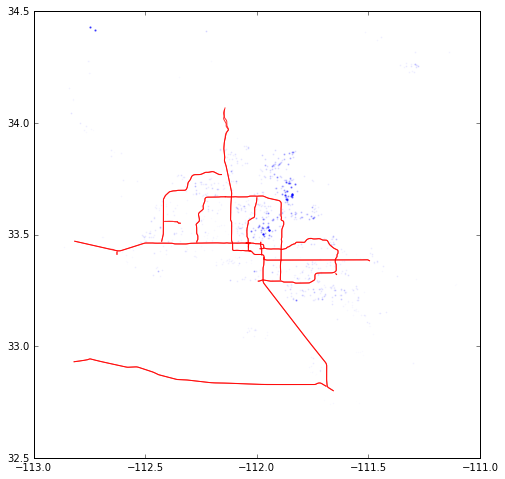

In [35]:
fig, ax = plt.subplots(figsize=(8,8))
gpd.GeoSeries(ops.linemerge(highway.geometry.values)).plot(alpha=0.8, ax=ax, color="red")

n=1000
alphas = home_sales.ClosePrice.values[:n]/np.sum(home_sales.ClosePrice.values[:n])
alphas = alphas/np.max(alphas)
for h,a in zip(houses[:n], alphas): 
    ax.scatter(*to_xy(h), alpha=a, s=1+a, color='blue')
ax.set_xlim(-113, -111)
ax.set_ylim(32.5, 34.5)

In [43]:
type(ax)

matplotlib.axes._subplots.AxesSubplot

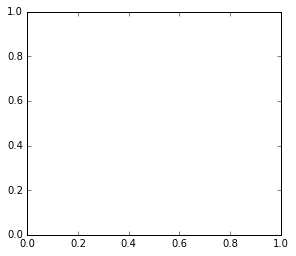

In [45]:
fig = pyplot.figure(1, figsize=(10, 4), dpi=180)

# 1
ax = fig.add_subplot(121)# for k in np.arange(0,20):
#     ax.scatter(0,1, alpha=0.1, s=0.1)
#     ax.scatter(np.random.random(), np.random.random(), alpha=0.1)
    
    
dilated = houses[0].buffer(10)
patch1 = descartes.PolygonPatch(dilated, alpha=1, color="red")
ax.add_patch(patch1)

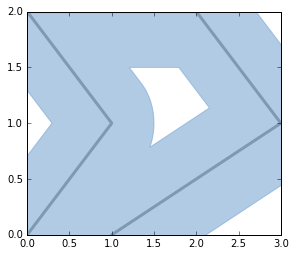

In [42]:
from matplotlib import pyplot
from shapely.geometry import LineString
from descartes import PolygonPatch

BLUE = '#6699cc'
GRAY = '#999999'

def plot_line(ax, ob):
    x, y = ob.xy
    ax.plot(x, y, color=GRAY, linewidth=3, solid_capstyle='round', zorder=1)

line = LineString([(0, 0), (1, 1), (0, 2), (2, 2), (3, 1), (1, 0)])

fig = pyplot.figure(1, figsize=(10, 4), dpi=180)

# 1
ax = fig.add_subplot(121)

plot_line(ax, line)

dilated = line.buffer(0.5)
patch1 = PolygonPatch(dilated, fc=BLUE, ec=BLUE, alpha=0.5, zorder=2)
ax.add_patch(patch1)

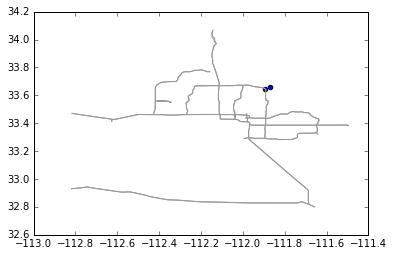

In [78]:
fig, ax = plt.subplots()
ax.scatter(*to_xy(houses[3]))
p = nearest_point(houses[3], highways)
plt.scatter(*to_xy(p))
gpd.GeoSeries(highways).plot(ax=ax)

In [72]:
def to_xy(point):
    p = point.xy
    return (p[0][0], p[1][0])

def nearest_point(point, line):
    return line.interpolate(line.project(point))

In [ ]:
# compute distance to any highway

In [84]:
highway_geom = ops.linemerge(highway.geometry.values)
house_highway = [nearest_point(h, highway_geom) for h in houses]

In [120]:
hav_distances = [haversine(to_xy(h), to_xy(p)) for h,p in zip(houses, house_highway)]

In [121]:
home_sales["HavDistance"] = hav_distances

In [122]:
home_sales.head()

,GeoLat,GeoLon,PostalCode,ClosePrice,Point,HavDistance
0,33.869599,-111.842285,85262,1950000.0,POINT (-111.842285 33.869599),24.663551
1,33.593540,-111.827666,85259,1500000.0,POINT (-111.827666 33.59354),6.188684
2,33.519680,-111.982004,85018,1900000.0,POINT (-111.982004 33.51968),5.998589
3,33.659654,-111.871157,85255,2859000.0,POINT (-111.871157 33.659654),2.476450
4,33.564383,-112.249207,85345,165000.0,POINT (-112.249207 33.564383),0.733053


In [396]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures

deg = 3
ridge = make_pipeline(PolynomialFeatures(degree=deg), Ridge(fit_intercept=False))
ridge.fit(data[["HavDistance"]], np.log(data.ClosePrice + 1))
ridge.score(data[["HavDistance"]], np.log(data.ClosePrice + 1))

0.018246852265237257

In [367]:
from sklearn.pipeline import make_pipeline
pipe = make_pipeline(PolynomialFeatures(), Ridge(fit_intercept=False))

In [370]:
from sklearn.grid_search import GridSearchCV
grid_search = GridSearchCV(pipe, dict(polynomialfeatures=np.arange(1,10)))

In [371]:
grid_search.fit(data[["HavDistance"]], np.log(data.ClosePrice + 1))

GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(steps=[('polynomialfeatures', PolynomialFeatures(degree=2, include_bias=True, interaction_only=False)), ('ridge', Ridge(alpha=1.0, copy_X=True, fit_intercept=False, max_iter=None,
   normalize=False, solver='auto', tol=0.001))]),
       fit_params={}, iid=True, loss_func=None, n_jobs=1,
       param_grid={'polynomialfeatures': array([1, 2, 3, 4, 5, 6, 7, 8, 9])},
       pre_dispatch='2*n_jobs', refit=True, score_func=None, scoring=None,
       verbose=0)

In [403]:
 ridge.predict(X).shape

(54563,)

In [424]:
max_distance = 20
mask = home_sales.HavDistance < max_distance
data = home_sales[mask]

X, y = data[["HavDistance"]], np.log(data.ClosePrice + 1)

In [423]:
from sklearn.linear_model import LinearRegression
deg = 5
model = make_pipeline(PolynomialFeatures(degree=deg), LinearRegression(fit_intercept=False))
model.fit(X, y)
r2_score(y.reshape(-1,1), model.predict(X).reshape(-1,1))

0.023633864238714608

In [ ]:
from sklearn.svm import SVR
deg = 5
model = SVR()
model.fit(X, y)
r2_score(y.reshape(-1,1), model.predict(X).reshape(-1,1))

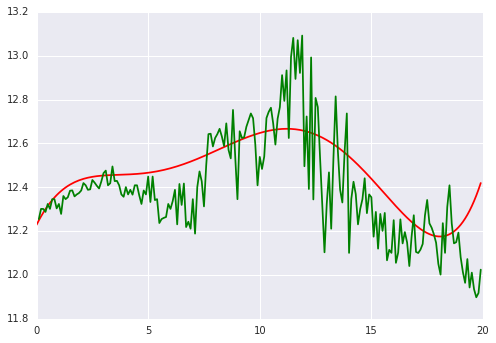

In [422]:
# grouping houses in bins of size dx
max_distance = 20
dx = 0.1
bins = np.arange(0,max_distance, dx)
prices_by_distance = [home_sales.loc[
        (home_sales.HavDistance < d) & (home_sales.HavDistance >= d - dx), 
        "ClosePrice"] for d in bins]

x = np.array(bins)
poly = np.poly1d(model.steps[-1][1].coef_[::-1])
plt.plot(x, poly(x), color="red")

plt.plot(bins, [np.log(p+1).median() for p in prices_by_distance], color='green')

In [218]:
# fit a ridge regression to distance versus closing price

count    57788.000000
mean         7.346276
std         18.267433
min          0.002603
25%          1.493858
50%          3.006973
75%          5.518644
max        254.697617
Name: HavDistance, dtype: float64

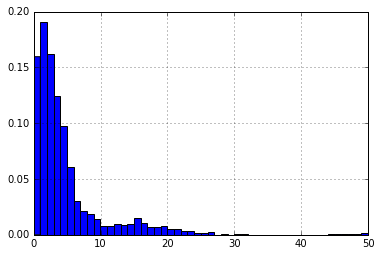

In [204]:
mask = home_sales.HavDistance < 50
home_sales.HavDistance[mask].hist(bins=50, normed=True)
home_sales.HavDistance.describe()

In [205]:
# proportion that live less than 1 km away
(home_sales.HavDistance <= 1).mean()

0.15506679587457603

Plots of housing prices grouped together by distance away from motorway

In [234]:
# grouping houses in bins of size dx
dx = 0.2
max_distance = 20
bins = np.arange(0,max_distance, dx)
prices_by_distance = [home_sales.loc[
        (home_sales.HavDistance < d) & (home_sales.HavDistance >= d - dx), 
        "ClosePrice"] for d in bins]

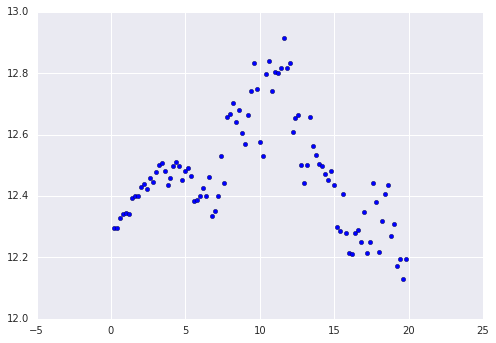

In [235]:
# mean plot
plt.scatter(bins, [np.log(p+1).mean() for p in prices_by_distance])

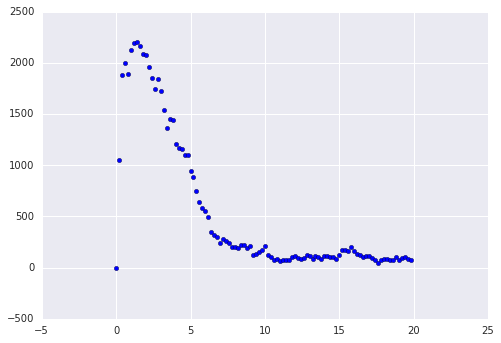

In [237]:
# number of plot
plt.scatter(bins, [len(p) for p in prices_by_distance])

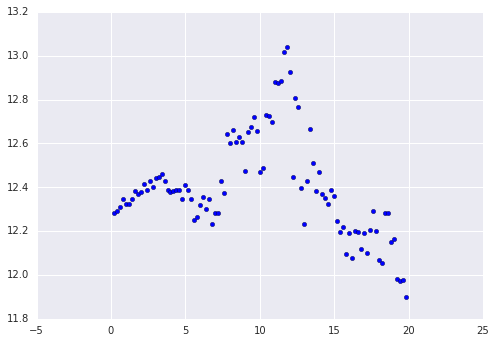

In [239]:
#median plot
plt.scatter(bins, [np.log(p+1).median() for p in prices_by_distance])

### Does being close to a highway affect housing prices

In [244]:
# 85% of people live within 10km of highway
(home_sales.HavDistance < 10).mean()

0.85552363812556242

In [219]:
close = home_sales[home_sales.HavDistance <= 1]
far = home_sales[home_sales.HavDistance > 1]

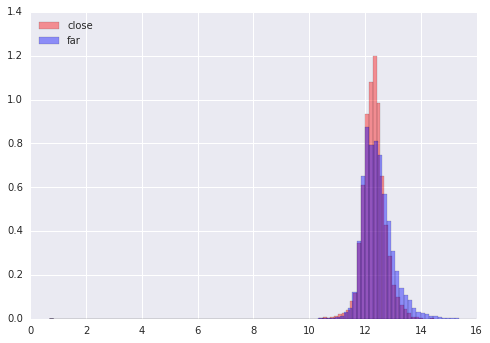

In [224]:
fig, ax = plt.subplots()
np.log(1+close.ClosePrice).hist(bins=100, ax=ax, color="red", 
                                alpha=0.4, normed=True,
                               label="close")
np.log(1+far.ClosePrice).hist(bins=100, ax=ax, color="blue", 
                              alpha=0.4, normed=True, label="far")
ax.legend(loc="upper left")

In [247]:
close.ClosePrice.describe().to_frame("close").join(far.ClosePrice.describe().to_frame("far"))

,close,far
count,8.961000e+03,4.882700e+04
mean,2.456859e+05,3.067158e+05
std,1.181172e+05,2.913138e+05
min,1.000000e+00,1.000000e+00
25%,1.770000e+05,1.750000e+05
50%,2.219000e+05,2.360000e+05
75%,2.800000e+05,3.380645e+05
max,1.950000e+06,8.725294e+06


In [245]:
close.ClosePrice.std()

118117.23155131232

In [226]:
far.ClosePrice.mean(), far.ClosePrice.median()

(306715.7631638233, 236000.0)

In [13]:
l = LineString([(0,0), (1,1)])
point = Point(0,1)
l.interpolate(l.project(point)).coords.xy

(array('d', [0.5]), array('d', [0.5]))

In [332]:
import sklearn

In [265]:
df = pd.DataFrame()
for key, value in grouped_highways.to_dict().items():
    df[key] = [h.distance(value) for h in houses]

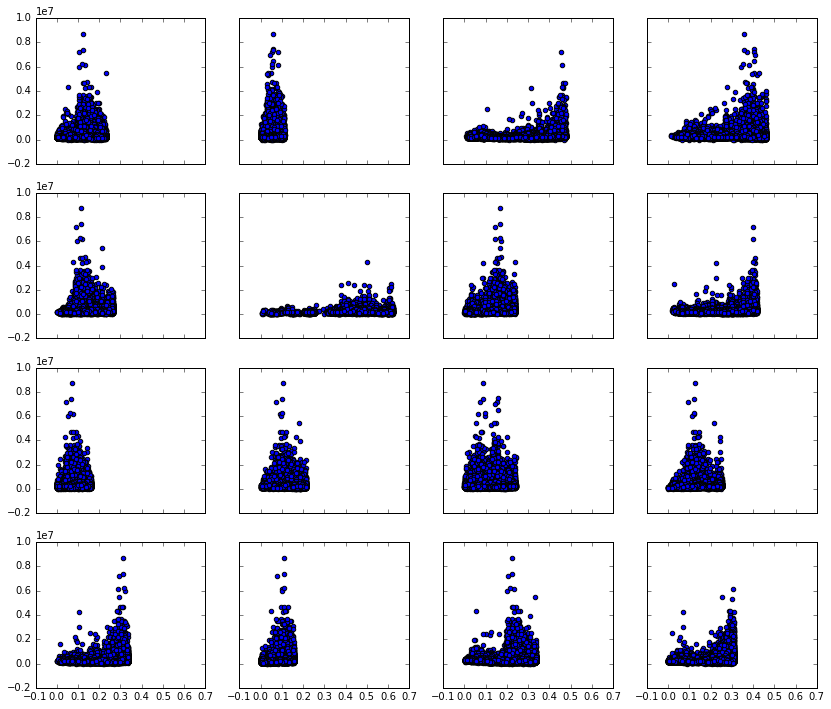

In [282]:
fig, ax = plt.subplots(figsize=(14,12), sharex=True, sharey=True, nrows=4, ncols=4)
for a,col in zip(ax.ravel(), df.columns):
    mask = (df[col] < df[col].quantile(0.5))
    a.scatter(df.loc[mask, col].values, home_sales.ClosePrice[mask])

In [377]:
df.shape

(57788, 20)

In [290]:
distance = df.min(axis=1).to_frame(name="Distance")
distance["Price"] = home_sales.ClosePrice

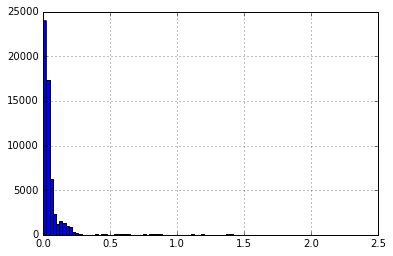

In [354]:
distance.Distance.hist(bins=100)

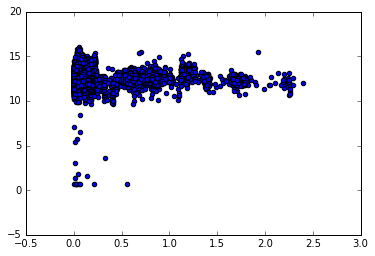

In [329]:
fig, ax = plt.subplots()
ax.scatter(distance.Distance, np.log(1+distance.Price))
# ax.set_xlim(-0.1, 0.1)

In [301]:
distance["Quantiles"] = pd.qcut(distance.Distance, q=1000)

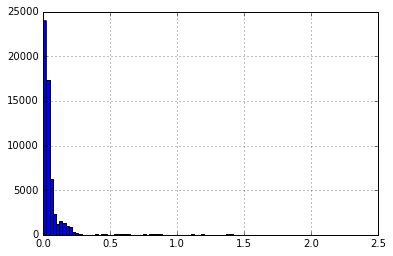

In [308]:
distance.Distance.hist(bins=100)

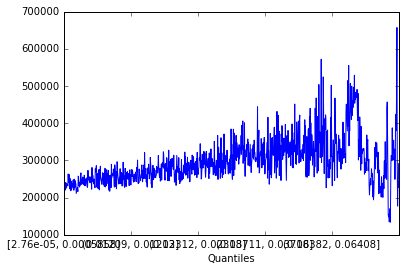

In [303]:
distance.groupby("Quantiles")["Price"].mean().plot()

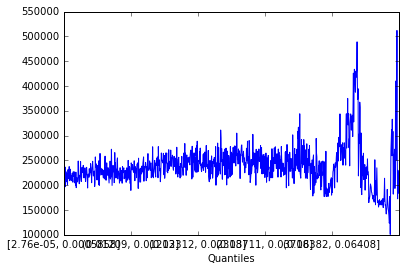

In [304]:
distance.groupby("Quantiles")["Price"].median().plot()

In [331]:
ridge.fit(distance[["Distance"]], np.log(1+home_sales.ClosePrice))
ridge.score(distance[["Distance"]], np.log(1+home_sales.ClosePrice))

3.1065572170918543e-05

In [225]:
motorway = ops.linemerge(highways.geometry.values)
distances = [h.distance(motorway) for h in houses]

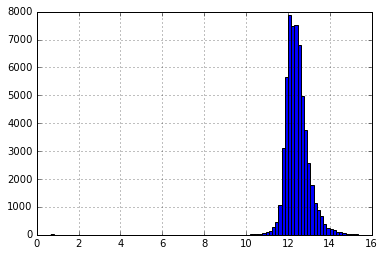

In [239]:
np.log(1+home_sales.ClosePrice).hist(bins=100)

In [254]:
data = home_sales.copy()
data["motor_distance"] = distances

In [255]:
# q0 = data.motor_distance.quantile(0.1)
# q1 = data.motor_distance.quantile(0.9)
# data = data[(data.motor_distance > q0) & (data.motor_distance < q1)]

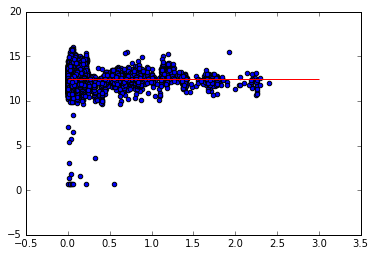

In [257]:
fig,ax = plt.subplots()
ax.scatter(data.motor_distance, np.log(data.ClosePrice + 1))
ax.hlines(np.log(data.ClosePrice+1).mean(), 0, 3, color="red")

In [356]:
residential = df_line[df_line.highway == "residential"]

In [358]:
residential.shape

(105413, 59)

In [217]:
df_line.name = df_line.name.fillna("Missing")
road_names = df_line[df_line.name.str.contains("North Cave Creek Road")]

In [362]:
residential.name.head()

13           Missing
14           Missing
18    Camelback Road
22           Missing
25           Missing
Name: name, dtype: object

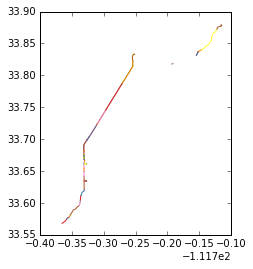

In [219]:
road_names.geometry.plot()

In [141]:
lines = ops.linemerge(residential.geometry.values)

In [204]:
[x if x=="a" else "C" for x in road_names[:5]]

['C', 'C', 'C', 'C', 'C']

In [187]:
p = box(-112.8, 33.784, -112.7, 33.8)


In [188]:
l2 = ops.linemerge(residential.head(100).geometry.values)

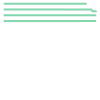

In [189]:
p.intersection(l2)

In [171]:
p.intersection(l2).bounds

(-112.8, 33.72307, -112.6858448, 33.8113092816795)

In [134]:
residential.head().dropna(1,"all")

,geometry,highway,name,oneway,osm_id,surface,tags,z_order
13,"LINESTRING (-112.8209618 32.927598, -112.82074...",residential,None,None,5577154.0,None,"""tiger:cfcc""=>""A41"", ""tiger:tlid""=>""128151964:...",3.0
14,"LINESTRING (-112.8209618 32.927598, -112.82050...",residential,None,None,5579972.0,None,"""tiger:cfcc""=>""A41"", ""tiger:tlid""=>""128151749""...",3.0
18,"LINESTRING (-112.8157387 33.5082509, -112.8186...",residential,Camelback Road,no,5611850.0,compacted,"""lanes""=>""2"", ""tiger:cfcc""=>""A51"", ""tiger:coun...",3.0
22,"LINESTRING (-112.8185138 34.021139, -112.81906...",residential,None,None,16952457.0,None,"""tiger:cfcc""=>""A41"", ""tiger:tlid""=>""159440843""...",3.0
25,"LINESTRING (-112.8195206 34.0486319, -112.8197...",residential,None,None,267486315.0,None,None,3.0


In [125]:
lines = ops.linemerge(residential.geometry.values)

In [127]:
s = gpd.GeoSeries(lines)

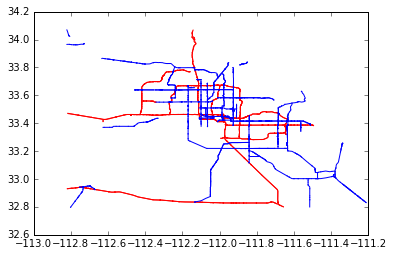

In [40]:
motorway = gpd.GeoDataFrame(
    df_line.loc[df_line.highway == "motorway", "geometry"]
    )

fig,ax=plt.subplots()
motorway.plot(ax=ax, color='red')
primary.plot(ax=ax, color='blue')

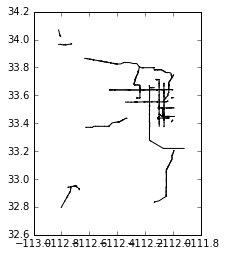

In [39]:
primary.head(1000).geometry.plot(color='black')

In [117]:
# compute distances to among houses

In [42]:
I10 = highways[highways.ref == "I 10"]

In [106]:
lines = linemerge(highways.geometry.values)

In [109]:
%%time
d_highways = [h.distance(lines) for h in houses]

CPU times: user 15.4 s, sys: 17 ms, total: 15.4 s
Wall time: 15.4 s


In [112]:
import numpy as np

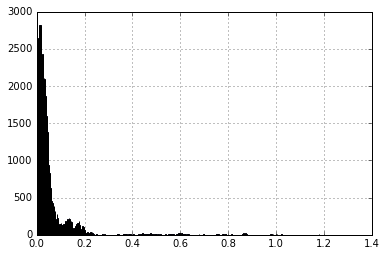

In [117]:
np.log(1+pd.Series(d_highways)).hist(bins=500) 

In [87]:
%%time
ds = [houses[0].distance(l) for l in I10.geometry.values]

CPU times: user 4.74 ms, sys: 587 µs, total: 5.33 ms
Wall time: 4.71 ms


In [86]:
min(ds)

0.4528822393402644

In [101]:
%%time
ds = [h.distance(lines) for h in houses]

CPU times: user 7.62 s, sys: 22.3 ms, total: 7.64 s
Wall time: 7.69 s


In [100]:
ds[0]

[0.45324630649978703,
 0.4528822393402644,
 0.4884715757331299,
 0.4925821718740205]

In [97]:
%%time
houses[0].distance(lines)

CPU times: user 575 µs, sys: 155 µs, total: 730 µs
Wall time: 393 µs


0.4528822393402644

In [96]:
%%time
[houses[0].distance(l) for l in list(lines.geoms)]

CPU times: user 875 µs, sys: 201 µs, total: 1.08 ms
Wall time: 817 µs


[0.45324630649978703,
 0.4528822393402644,
 0.4884715757331299,
 0.4925821718740205]

In [94]:
ds[0]

[0.45324630649978703,
 0.4528822393402644,
 0.4884715757331299,
 0.4925821718740205]

In [74]:
l1 = list(lines.geoms)[0]
l2 = list(lines.geoms)[1]

In [78]:
s = l1.union(l2)

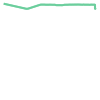

In [79]:
s

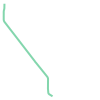

In [66]:
list(lines.geoms)[2]

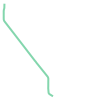

In [67]:
list(lines.geoms)[3]

In [113]:
l1 = LineString([[0,0], [1,1]])
l2 = LineString([[0,0], [0,12]])

In [36]:
home_sales.GeoLat.min(), home_sales.GeoLat.max()

(31.349674, 35.519119000000003)

In [37]:
home_sales.GeoLon.min(), home_sales.GeoLon.max()

(-114.535751, -109.45778500000002)

(32.5, 34)

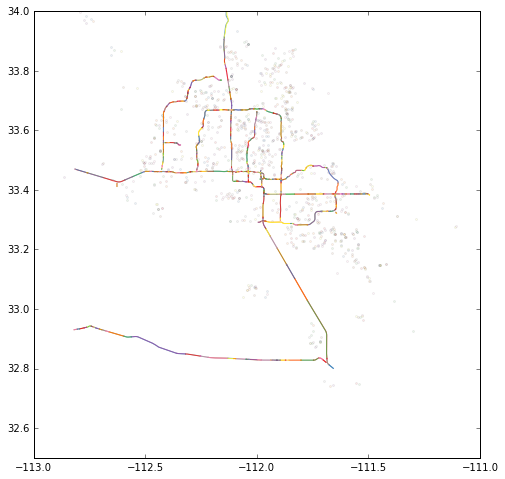

In [84]:
fig, ax = plt.subplots(figsize=(8,8))
gpd.GeoSeries(home_sales.Point).head(1000).plot(ax=ax, alpha=0.1)
(motors
 .sort_values("Length", ascending=False)
 .head(1000)
 .geometry
 .plot(ax=ax, alpha=0.8)
 )
ax.set_xlim(-113, -111)
ax.set_ylim(32.5, 34)

In [85]:
roads.head()

,highway,geometry
0,None,"LINESTRING (-112.8209996 33.2998696, -112.8209..."
1,None,"LINESTRING (-112.8209923 33.2989852, -112.8209..."
2,None,"LINESTRING (-112.8209948 33.2992758, -112.8209..."
3,None,"LINESTRING (-112.8209973 33.2995722, -112.8209..."
4,None,"LINESTRING (-112.8209941 34.0687693, -112.8203..."


In [76]:
motors = gpd.GeoDataFrame(roads[roads.highway == "motorway"].geometry)
motors["Length"] = motors.geometry.length

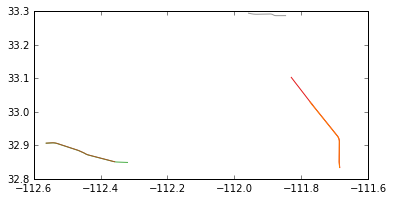

In [78]:
motors.sort_values("Length", ascending=False).head().geometry.plot()

In [52]:
%%time
roads.groupby("highway")["geometry"].agg(lambda x: max_min_distances(x, houses[0]))

CPU times: user 3.18 s, sys: 22.3 ms, total: 3.2 s
Wall time: 3.21 s


highway
abandoned           (0.556141980164, 1.29900010918)
bridleway          (0.173734457474, 0.597424513536)
construction        (0.129535408113, 1.07745238075)
cycleway           (0.191557685738, 0.981043182143)
dismantled         (0.441265538489, 0.450044117885)
footway            (0.0146370147042, 1.07830635698)
living_street      (0.372111132116, 0.459353317347)
motorway            (0.224351798501, 1.34313258226)
motorway_link       (0.224060237345, 1.34314303706)
path                (0.055928250836, 1.08271943967)
pedestrian         (0.431089318217, 0.823336736866)
primary             (0.033405504682, 1.43776706258)
primary_link       (0.0554479559373, 1.30009461805)
proposed           (0.0916471613152, 1.27496132107)
raceway             (0.234867435041, 1.03435797088)
residential       (0.00040376023447, 1.43341541291)
road               (0.0965818993438, 1.25133290042)
secondary         (0.00691582041554, 1.25675734823)
secondary_link     (0.0373144005372, 1.00168296849)
serv

In [23]:
max_min_distances(highways, houses[0])

(205.18140098269072, 206.47267446103976)

In [41]:
def max_min_distances(roads, house):
    distances = roads.apply(lambda x: house.distance(x))
    return (distances.min(), distances.max())

In [20]:
motors = roads[roads.highway == "motorway"].geometry.values

In [13]:
p = Point(0,1)
l = LineString([[0,0], [1,1]])
p.distance(l) == l.distance(p)

True

In [46]:
h.distance(l)

206.0895760852905

In [10]:
data_shp[data_shp.geometry.type == "Line"].head()

,ALAND10,AWATER10,CLASSFP10,FUNCSTAT10,GEOID10,INTPTLAT10,INTPTLON10,MTFCC10,PARTFLG10,STATEFP10,ZCTA5CE10,geometry


In [11]:
data_shp.geometry.type.unique()

array(['Polygon', 'MultiPolygon'], dtype=object)

In [94]:
motorways = df_line[df_line.highway == "motorway"]

In [102]:
GRAY = '#999999'
def plot_line(ax, ob, color=GRAY, zorder=1):
    x, y = ob.xy
    ax.plot(x, y, color=GRAY, linewidth=3, solid_capstyle='round', zorder=zorder)

In [104]:
motorways[["geometry", "zo"]]

,access,aerialway,aeroway,amenity,area,barrier,bicycle,boundary,brand,bridge,...,tower:type,tracktype,tunnel,water,waterway,way_area,wetland,width,wood,z_order
126,None,None,None,None,None,None,yes,None,None,None,...,None,None,None,None,None,None,None,None,None,9.0
128,None,None,None,None,None,None,yes,None,None,None,...,None,None,None,None,None,None,None,None,None,9.0
216,None,None,None,None,None,None,yes,None,None,None,...,None,None,None,None,None,None,None,None,None,9.0
218,None,None,None,None,None,None,yes,None,None,None,...,None,None,None,None,None,None,None,None,None,9.0
264,None,None,None,None,None,None,yes,None,None,yes,...,None,None,None,None,None,None,None,None,None,29.0


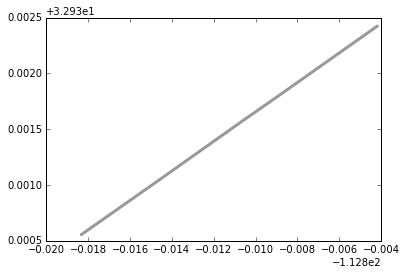

In [103]:
fig, ax = plt.subplots()
for row in 
plot_line(ax, motorways.geometry.iloc[0])

In [91]:
fig = pylab.figure(figsize=(50, 24), dpi=180)

n = 12
for state,color in zip(motorways.geometry.values, matplotlib.colors.cnames.values()):
    try:
        poly_patch = PolygonPatch(poly, fc=color, ec="black", alpha=0.5, zorder=0)
        fig.gca().add_patch(poly_patch)
    except:
        pass

# fig.gca().plot(*ls.xy, color='#FFFFFF')

# for x, y in path:
#     p = Point(x, y)
#     spot = p.buffer(.1)
#     x, y = spot.exterior.xy
#     pylab.fill(x, y, color='#cc6666', aa=True)
#     pylab.plot(x, y, color='#cc6666', aa=True, lw=1.0)

fig.gca().axis([-112, -113, 33, 34])
# fig.gca().axis('off')
plt.savefig("polygon2.png", figsize=(8,11), dpi=200)

0    None
1    None
2    None
3    None
4      89
Name: ref, dtype: object

In [90]:
df_line[df_line.highway == "motorway"].head().dropna(1, "all").ref

126     I 8
128     I 8
216    I 10
218    I 10
264    I 10
Name: ref, dtype: object

In [ ]:
# df_point = fiona.read_file("./phoenix_arizona.osm2pgsql-geojson/phoenix_arizona_osm_point.geojson")

In [ ]:
df_poly = geopandas.read_file("./phoenix_arizona.osm2pgsql-geojson/phoenix_arizona_osm_polygon.geojson")

In [14]:
df_poly["Distance"] = df_poly.geometry.length
polys = df_poly.sort_values("Distance", ascending = False)

In [98]:
from shapely.geometry import shape, LineString, Point
from descartes import PolygonPatch
import fiona, pylab

In [41]:
polys.head().dropna(1,"all")

,boundary,geometry,name,osm_id,place,tags,way_area,z_order,Distance
7266,administrative,"POLYGON ((-112.3240287 33.5096918, -112.324028...",Phoenix,-111257.0,city,"""is_in""=>""USA, Arizona"", ""admin_level""=>""8"", ""...",0.131332,0.0,4.963388
55051,administrative,"POLYGON ((-111.893982 33.3636502, -111.8934048...",Mesa,-110815.0,city,"""admin_level""=>""8"", ""tiger:reviewed""=>""no""",0.033046,0.0,2.753638
4796,administrative,"POLYGON ((-112.4472988 33.825726, -112.4471278...",Peoria,-110691.0,city,"""is_in""=>""USA, Arizona"", ""wikipedia""=>""en:Peor...",0.045359,0.0,2.416267
4548,administrative,"POLYGON ((-112.4959198 33.261508, -112.4958118...",Goodyear,-110809.0,None,"""admin_level""=>""8""",0.030074,0.0,2.064992
4547,administrative,"POLYGON ((-112.4959198 33.261508, -112.4958118...",Goodyear,-110810.0,city,"""admin_level""=>""8"", ""tiger:reviewed""=>""no""",0.030074,0.0,2.064992


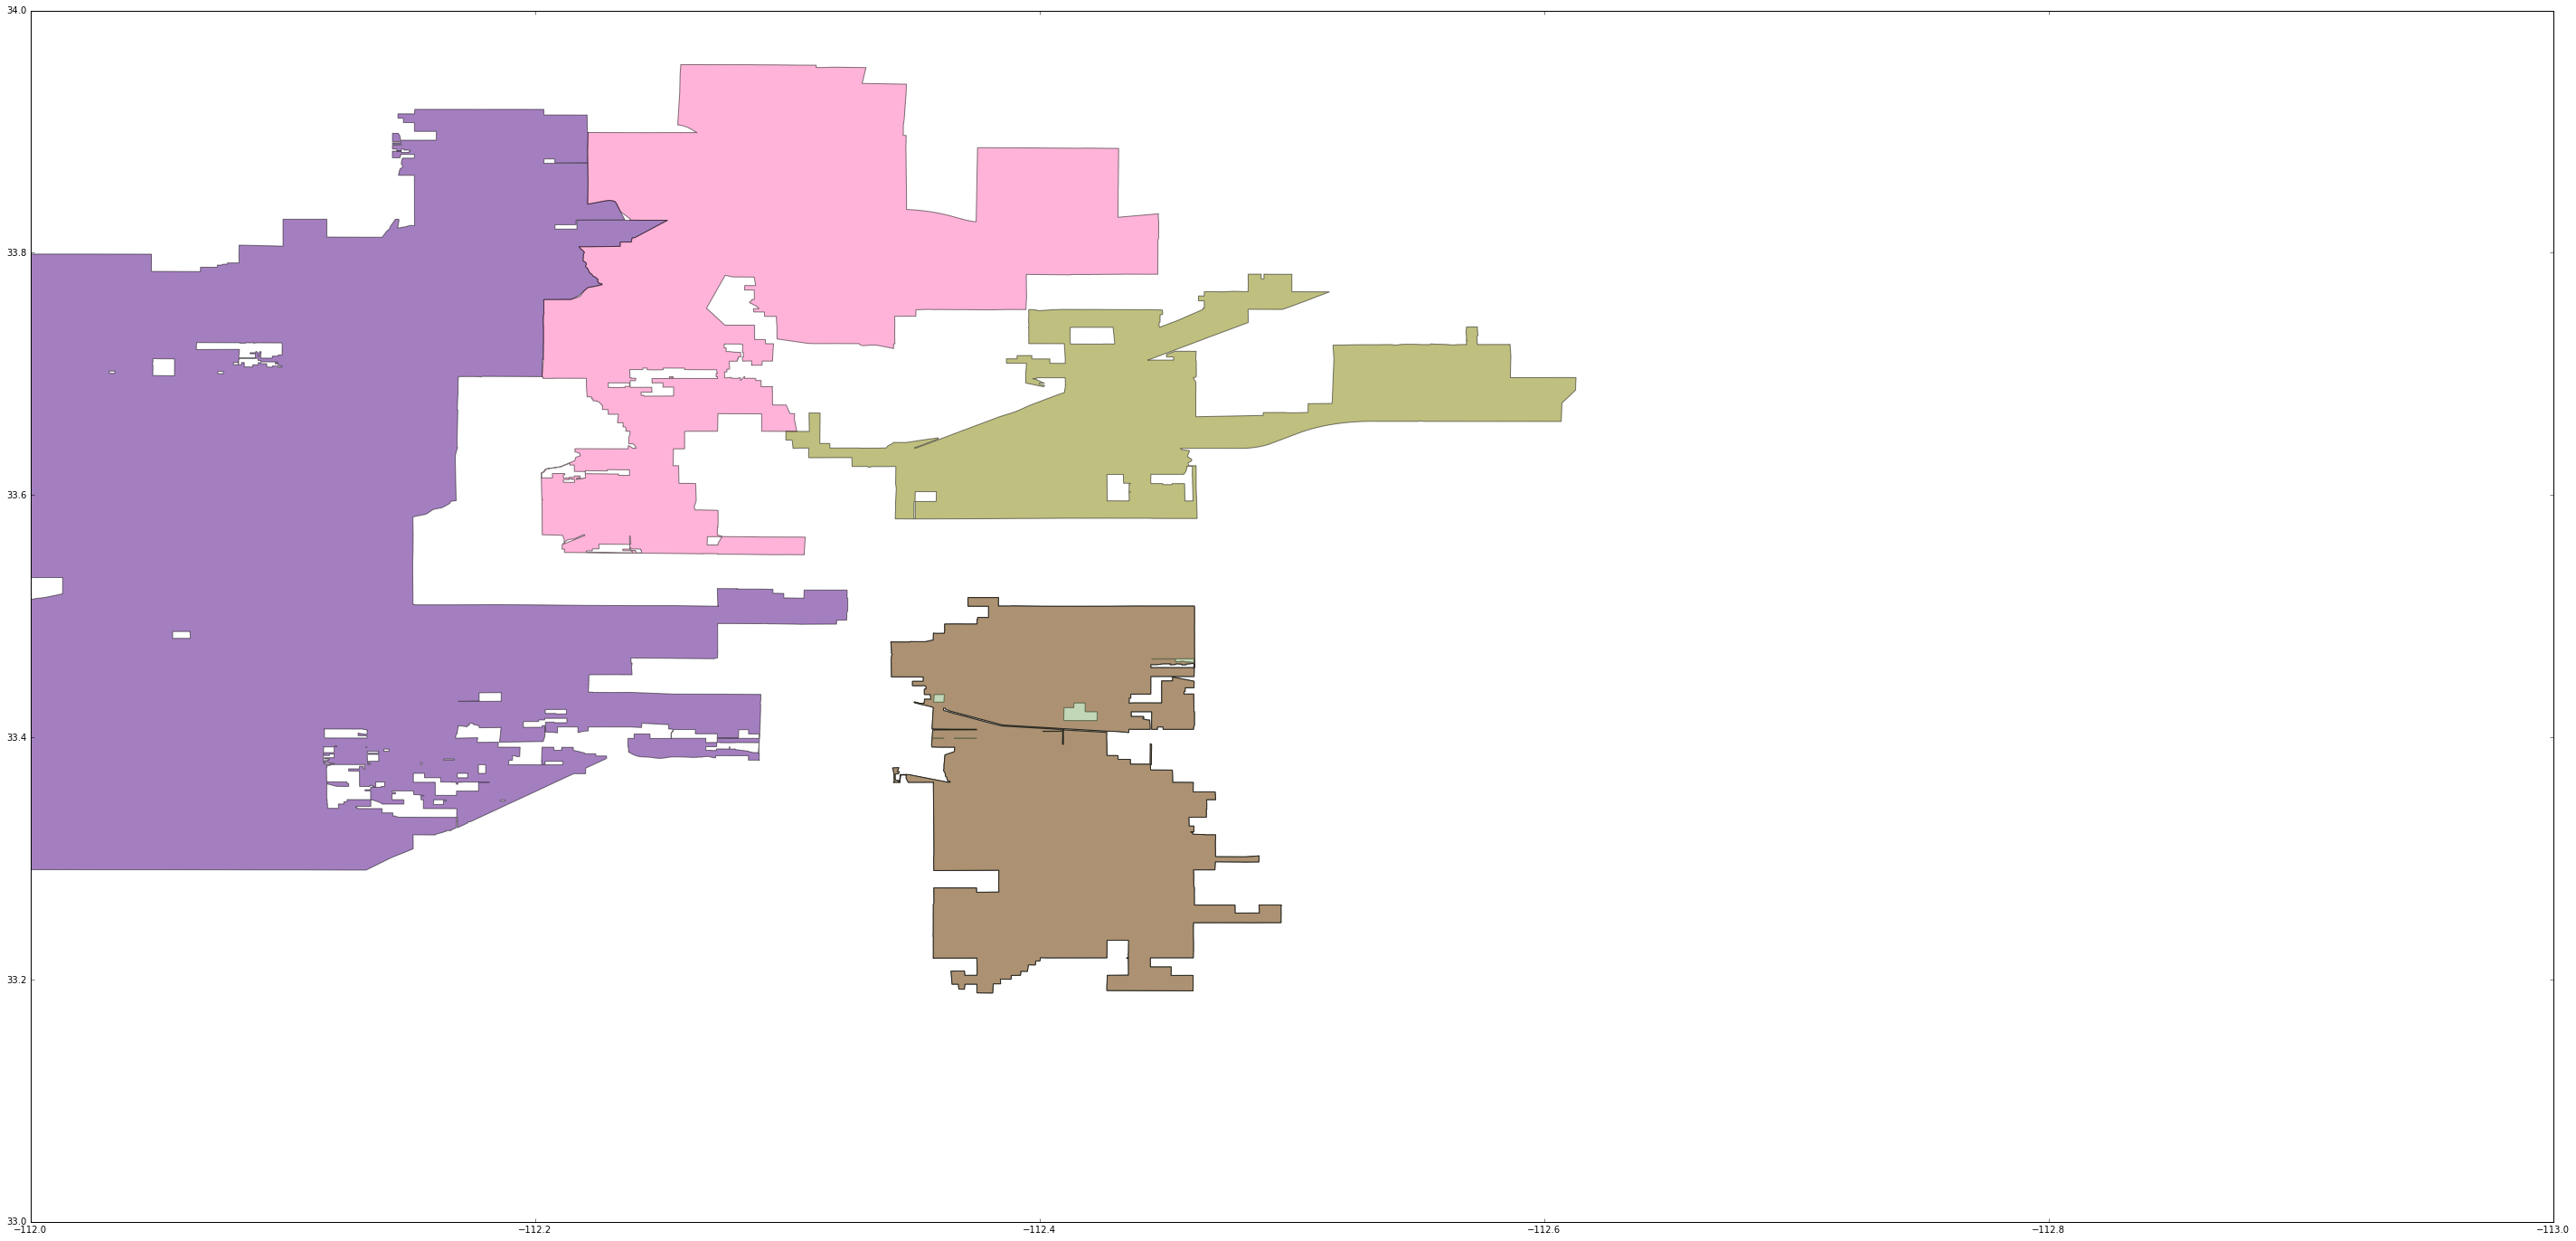

In [64]:
fig = pylab.figure(figsize=(50, 24), dpi=180)

n = 12
for state,color in zip(polys.geometry.values[:n], matplotlib.colors.cnames.values()):
    if state.geom_type == 'Polygon':
        state = [state]

    for poly in state:
        try:
            poly_patch = PolygonPatch(poly, fc=color, ec="black", alpha=0.5, zorder=0)
            fig.gca().add_patch(poly_patch)
        except:
            pass

# fig.gca().plot(*ls.xy, color='#FFFFFF')

# for x, y in path:
#     p = Point(x, y)
#     spot = p.buffer(.1)
#     x, y = spot.exterior.xy
#     pylab.fill(x, y, color='#cc6666', aa=True)
#     pylab.plot(x, y, color='#cc6666', aa=True, lw=1.0)

fig.gca().axis([-112, -113, 33, 34])
# fig.gca().axis('off')
plt.savefig("polygon2.png", figsize=(8,11), dpi=200)

(-125.0, -65.0, 25.0, 50.0)

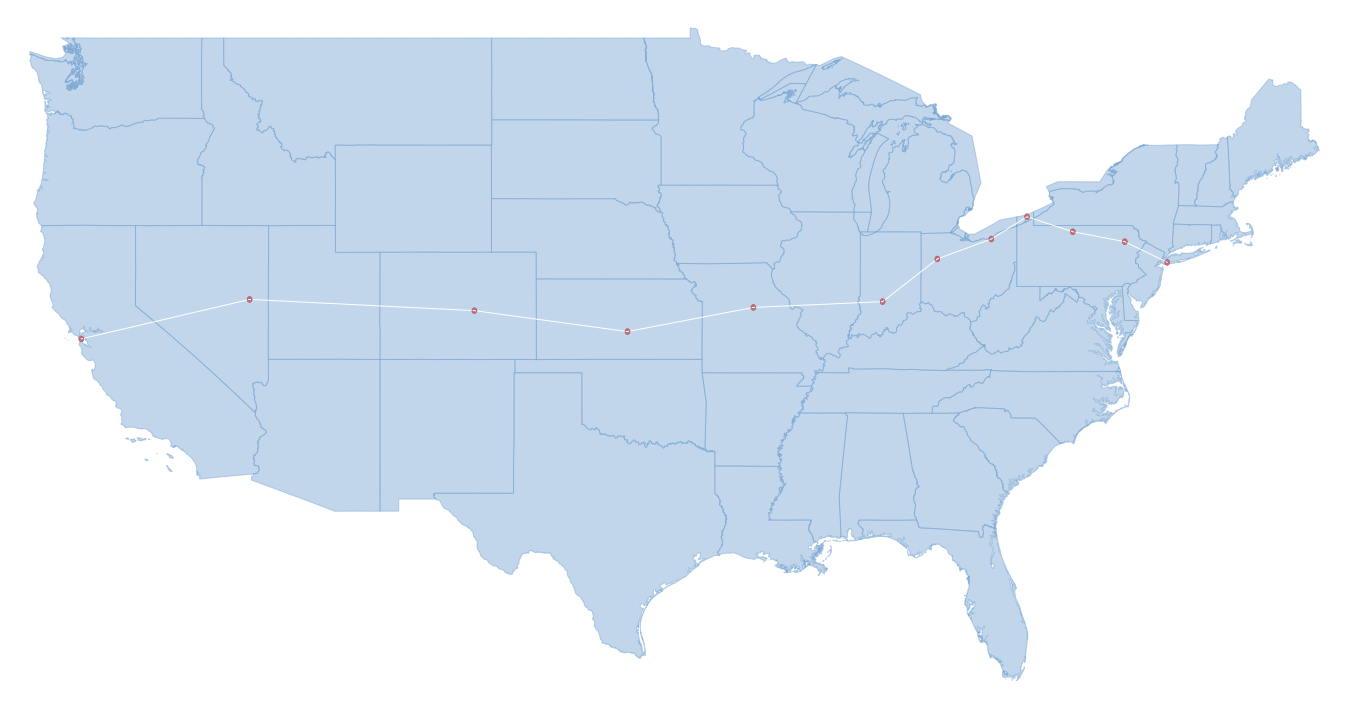

In [8]:
latlons = [(37.766, -122.43), (39.239, -114.89), (38.820, -104.82), (38.039, -97.96),
    (38.940, -92.32), (39.156, -86.53), (40.749, -84.08), (41.494, -81.66),
    (42.325, -80.06), (41.767, -78.01), (41.395, -75.68), (40.625, -73.780)]
path = [(x, y) for y, x in latlons]
ls = LineString(path)

with fiona.collection("./ZainShapely/shapefiles/statesp020.shp") as features:
    states = [shape(f['geometry']) for f in features]

fig = pylab.figure(figsize=(24, 12), dpi=180)

for state in states:
    if state.geom_type == 'Polygon':
        state = [state]

    for poly in state:
        if ls.intersects(poly):
            alpha = 0.4
        else:
            alpha = 0.4

        try:
            poly_patch = PolygonPatch(poly, fc="#6699cc", ec="#6699cc", alpha=alpha, zorder=2)
            fig.gca().add_patch(poly_patch)
        except:
            pass

fig.gca().plot(*ls.xy, color='#FFFFFF')

for x, y in path:
    p = Point(x, y)
    spot = p.buffer(.1)
    x, y = spot.exterior.xy
    pylab.fill(x, y, color='#cc6666', aa=True)
    pylab.plot(x, y, color='#cc6666', aa=True, lw=1.0)

fig.gca().axis([-125, -65, 25, 50])
fig.gca().axis('off')